# Modèle de prédiction d'une réponse fermée multi-classe

## Imports

In [17]:
import csv, sys
import tensorflow as tf
import csv, sys
%env TF_FORCE_GPU_ALLOW_GROWTH=true
# %matplotlib widget
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from tensorflow import keras
from keras.layers import TextVectorization
from keras.optimizers import Adam
from keras_tuner import HyperParameters, RandomSearch

env: TF_FORCE_GPU_ALLOW_GROWTH=true


In [18]:
tf.config.run_functions_eagerly(True)

# Récupération et préparation des données 

In [19]:
# fichier
csv.field_size_limit(sys.maxsize)

liste = ["Les dérèglements climatiques (crue, sécheresse)", "La pollution de l'air", "La biodiversité et la disparition de certaines espèces", "L'érosion du littoral"]
with open("../LA_TRANSITION_ECOLOGIQUE.csv") as f:
    reader = csv.reader(f)
    header = next(reader)
    questions_ouvertes = [header[12], header[17], header[18], header[24], header[25], header[26]]
    print("Questions ouvertes choisies:\n")
    for ele in questions_ouvertes: 
        print(ele+"\n")
    print("\n\n")
    print(f"Question fermée choisie\n: {header[11]}")
    label = []
    text = []
    for row in reader:
        if row[12] != '' and row[11] in liste and row[17] != '' and  row[18] != '' and row[24] != '' and row[25] != '' and row[26] != '': 
            text.append(row[12] + " "+ row[17] + " "+ row[18] + " "+ row[24] + " "+ row[25]  + " "+ row[26]  ), label.append(row[11])

print(len(text))

Questions ouvertes choisies:

QUXVlc3Rpb246MTYx - Que faudrait-il faire selon vous pour apporter des réponses à ce problème ?

QUXVlc3Rpb246MTUw - Qu'est-ce qui pourrait vous inciter à changer vos comportements comme par exemple mieux entretenir et régler votre chauffage, modifier votre manière de conduire ou renoncer à prendre votre véhicule pour de très petites distances ?

QUXVlc3Rpb246MTUx - Quelles seraient pour vous les solutions les plus simples et les plus supportables sur un plan financier pour vous inciter à changer vos comportements ?

QUXVlc3Rpb246MTU3 - Et qui doit selon vous se charger de vous proposer ce type de solutions alternatives ?

QUXVlc3Rpb246MTU4 - Que pourrait faire la France pour faire partager ses choix en matière d'environnement au niveau européen et international ?

QUXVlc3Rpb246MTU5 - Y a-t-il d'autres points sur la transition écologique sur lesquels vous souhaiteriez vous exprimer ?




Question fermée choisie
: QUXVlc3Rpb246MTYw - Quel est aujourd'hui po

In [20]:
print(label[1])

La biodiversité et la disparition de certaines espèces


In [21]:
text_vectorizer = TextVectorization(max_tokens=1000,
                                            output_sequence_length=1000,
                                            standardize='lower_and_strip_punctuation',
                                            split='whitespace',
                                            output_mode='int')

In [22]:
text_vectorizer.adapt(text)

In [23]:
X_traindev_raw, X_test_raw, Y_traindev_raw, Y_test_raw = train_test_split(text, label, train_size=0.8, shuffle=False)
X_train_raw, X_dev_raw, Y_train_raw, Y_dev_raw = train_test_split(X_traindev_raw, Y_traindev_raw, train_size=0.8, shuffle=False)

In [24]:
from keras.utils import to_categorical
dico_labels = {"Les dérèglements climatiques (crue, sécheresse)": 0, "La pollution de l'air": 1, "La biodiversité et la disparition de certaines espèces": 2, "L'érosion du littoral": 3}

training_data = np.array(X_train_raw)
training_labels = np.array([dico_labels[d] for d in Y_train_raw])
Y_train_ok = to_categorical(training_labels)

dev_data = np.array(X_dev_raw)
dev_labels = np.array([dico_labels[d] for d in Y_dev_raw])
Y_dev_ok = to_categorical(dev_labels)

testing_data = np.array(X_test_raw)
testing_labels = np.array([dico_labels[d] for d in Y_test_raw])
Y_test_ok = to_categorical(testing_labels)

In [25]:
print(Y_train_ok[1], label[1])

[0. 0. 1. 0.] La biodiversité et la disparition de certaines espèces


In [26]:
X_train_ok = text_vectorizer(training_data)
X_dev_ok = text_vectorizer(dev_data)
X_test_ok = text_vectorizer(testing_data)
print(X_train_ok.shape, X_dev_ok.shape, X_test_ok.shape)

(24228, 1000) (6058, 1000) (7572, 1000)


# Construction du modèle

In [35]:
def build_model(tv): 
      inputs = keras.layers.Input(shape=(tv.vocabulary_size(),))
      embeddings = keras.layers.Embedding(input_dim=tv.vocabulary_size(),
                                        output_dim=64,
                                        name='emb'
                                       )(inputs)
      pooling = keras.layers.GlobalAveragePooling1D()(embeddings)
      dropout = keras.layers.Dropout(0.5)(pooling)
      dense1 = keras.layers.Dense(10, activation="relu", use_bias=True)(dropout)
      dropout2 = keras.layers.Dropout(0.5)(dense1)    
      dense = keras.layers.Dense(4, activation="softmax", use_bias=True)(dropout2)
      model = keras.Model(inputs=inputs, outputs=dense)
      model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=["accuracy"])
      return model

In [36]:
model = build_model(text_vectorizer)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1000)]            0         
                                                                 
 emb (Embedding)             (None, 1000, 64)          64000     
                                                                 
 global_average_pooling1d_3   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 10)                650       
                                                                 
 dropout_7 (Dropout)         (None, 10)                0         
                                                           

In [37]:
model.fit(x=X_train_ok, y=Y_train_ok, epochs=50, batch_size=32, validation_data=(X_dev_ok, Y_dev_ok), verbose=1)

Epoch 1/50
  9/758 [..............................] - ETA: 10s - loss: 1.3715 - accuracy: 0.3194

/opt/homebrew/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


758/758 [==============================] - 9s 11ms/step - loss: 1.1860 - accuracy: 0.3871 - val_loss: 1.1188 - val_accuracy: 0.3929
Epoch 2/50
758/758 [==============================] - 9s 11ms/step - loss: 1.1417 - accuracy: 0.4134 - val_loss: 1.1140 - val_accuracy: 0.3929
Epoch 3/50
758/758 [==============================] - 8s 11ms/step - loss: 1.1304 - accuracy: 0.4136 - val_loss: 1.1123 - val_accuracy: 0.3929
Epoch 4/50
758/758 [==============================] - 9s 12ms/step - loss: 1.1260 - accuracy: 0.4146 - val_loss: 1.1097 - val_accuracy: 0.3929
Epoch 5/50
758/758 [==============================] - 9s 12ms/step - loss: 1.1230 - accuracy: 0.4137 - val_loss: 1.1068 - val_accuracy: 0.3953
Epoch 6/50
758/758 [==============================] - 9s 12ms/step - loss: 1.1068 - accuracy: 0.4272 - val_loss: 1.0726 - val_accuracy: 0.4393
Epoch 7/50
758/758 [==============================] - 9s 12ms/step - loss: 1.0740 - accuracy: 0.4528 - val_loss: 1.0322 - val_accuracy: 0.4843
Epoch 8/50

In [38]:
score = model.evaluate(X_test_ok, Y_test_ok )

print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

237/237 [==============================] - 1s 4ms/step - loss: 0.9207 - accuracy: 0.5638
Test loss: 0.9206590056419373
Test accuracy: 0.5637876391410828


# Visualisation des données et des prédictions

In [39]:
import numpy as np 
import matplotlib.pyplot as plt 

pred = model.predict(X_test_ok)
  
pred0 = [np.argmax(ele) for ele in pred if np.argmax(ele)==0 ]
pred1 = [np.argmax(ele) for ele in pred if np.argmax(ele)==1 ]
pred2 = [np.argmax(ele) for ele in pred if np.argmax(ele)==2 ]
pred3 = [np.argmax(ele) for ele in pred if np.argmax(ele)==3 ]

train0 = [np.argmax(ele) for ele in Y_train_ok if np.argmax(ele)==0 ]
train1 = [np.argmax(ele) for ele in Y_train_ok if np.argmax(ele)==1 ]
train2 = [np.argmax(ele) for ele in Y_train_ok if np.argmax(ele)==2 ]
train3 = [np.argmax(ele) for ele in Y_train_ok if np.argmax(ele)==3 ]

dev0 = [np.argmax(ele) for ele in Y_dev_ok if np.argmax(ele)==0 ]
dev1 = [np.argmax(ele) for ele in Y_dev_ok if np.argmax(ele)==1 ]
dev2 = [np.argmax(ele) for ele in Y_dev_ok if np.argmax(ele)==2 ]
dev3 = [np.argmax(ele) for ele in Y_dev_ok if np.argmax(ele)==3 ]

test0 = [np.argmax(ele) for ele in Y_test_ok if np.argmax(ele)==0 ]
test1 = [np.argmax(ele) for ele in Y_test_ok if np.argmax(ele)==1 ]
test2 = [np.argmax(ele) for ele in Y_test_ok if np.argmax(ele)==2 ]
test3 = [np.argmax(ele) for ele in Y_test_ok if np.argmax(ele)==3 ]

label0 = [len(train0), len(dev0), len(test0), len(pred0)]
label1 = [len(train1), len(dev1), len(test1), len(pred1)]
label2 = [len(train2), len(dev2), len(test2), len(pred2)]
label3 = [len(train3), len(dev3), len(test3), len(pred3)]

X = ['Train', 'Dev', 'Test', 'Prédiction']

dico = {liste[0]: label0, liste[1]: label1, liste[2]: label2, liste[3]: label3}
print(dico)
x = np.arange(len(X))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for categorie, valeurs in dico.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, valeurs, width, label=categorie)
    ax.bar_label(rects, padding=4)
    multiplier += 1

ax.set_ylabel('Nombre de labels')
ax.set_title('Répartition des catégories dans les données et dans les prédictions')
ax.set_xticks(x + width, X)
ax.legend(loc='upper left')

plt.show()

237/237 [==============================] - 1s 3ms/step
{'Les dérèglements climatiques (crue, sécheresse)': [10028, 2380, 2802, 4642], "La pollution de l'air": [6355, 1492, 1930, 713], 'La biodiversité et la disparition de certaines espèces': [7644, 2148, 2812, 2217], "L'érosion du littoral": [201, 38, 28, 0]}


 35/237 [===>..........................] - ETA: 0s

/opt/homebrew/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


237/237 [==============================] - 1s 2ms/step


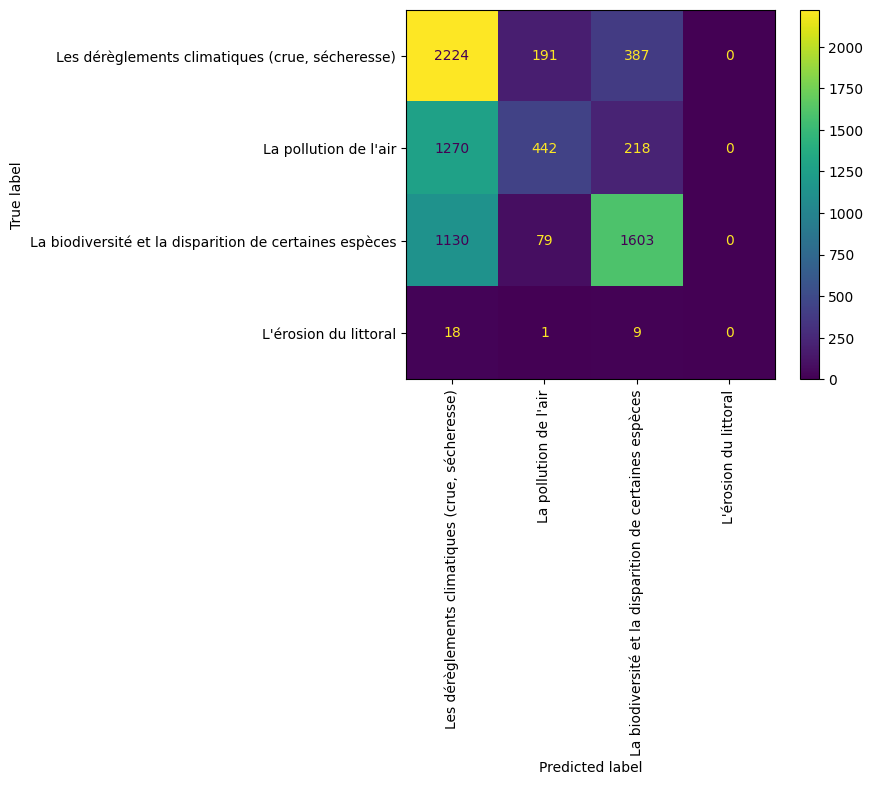

In [41]:
import seaborn as sns 
# Try resetting it 
sns.reset_orig() 
Y_output = model.predict(X_test_ok)
Y_prediction = np.argmax(Y_output, axis=1)

cm = confusion_matrix(np.argmax(Y_test_ok, axis=1), Y_prediction)
cm2 = ConfusionMatrixDisplay(cm, display_labels=liste)
cm2.plot(xticks_rotation="vertical")

# Tuning

In [47]:
def build_model(tv, emb_size, learning_rate, dropout_rate, nb_neuron): 
      inputs = keras.layers.Input(shape=(tv.vocabulary_size(),))
      embeddings = keras.layers.Embedding(input_dim=tv.vocabulary_size(),
                                        output_dim=emb_size,
                                        name='emb'
                                       )(inputs)
      pooling = keras.layers.GlobalAveragePooling1D()(embeddings)
      dropout = keras.layers.Dropout(dropout_rate)(pooling)
      dense1 = keras.layers.Dense(nb_neuron, activation="relu", use_bias=True)(dropout)
      dropout2 = keras.layers.Dropout(dropout_rate)(dense1)    
      dense = keras.layers.Dense(4, activation="softmax", use_bias=True)(dropout2)
      model = keras.Model(inputs=inputs, outputs=dense)
      model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=["accuracy"])
      return model

In [45]:
def hypermodel(hp: HyperParameters)-> keras.Model:
    lr = hp.Float("learning_rate", min_value=0.01,
                  max_value=0.1,
                  #step=5,
                  sampling='log')
    
    emb_size = hp.Int('emb_size', min_value=100, 
                      max_value=1000, 
                      step=5)
    nb_neuron = hp.Int('nb_neuron', min_value=100, 
                    max_value=1000, 
                    step=5)
    dropout_rate  = hp.Float('dropout_rate', min_value=0.1, 
                    max_value=0.9, 
                    step=5)
 

    return build_model(text_vectorizer, emb_size=emb_size, learning_rate=lr, nb_neuron=nb_neuron, dropout_rate=dropout_rate)

In [48]:
tuner = RandomSearch(
    hypermodel=hypermodel, #fonction qui génère des modèles en fonction d'un hyperparamètre
    objective='val_accuracy',
    max_trials=5,
    project_name='multiclass_1input')

In [49]:
tuner.search(X_train_ok, Y_train_ok, validation_data=(X_dev_ok, Y_dev_ok), epochs=10)

Trial 5 Complete [00h 02m 22s]
val_accuracy: 0.5876526832580566

Best val_accuracy So Far: 0.5879828333854675
Total elapsed time: 00h 16m 35s
INFO:tensorflow:Oracle triggered exit


In [50]:
tuner.results_summary()
best_model = tuner.get_best_models(1)[0]

Results summary
Results in ./multiclass_1input
Showing 10 best trials
Trial summary
Hyperparameters:
learning_rate: 0.01832226882454747
emb_size: 175
nb_neuron: 125
dropout_rate: 0.1
Score: 0.5879828333854675
Trial summary
Hyperparameters:
learning_rate: 0.019328719126885715
emb_size: 180
nb_neuron: 850
dropout_rate: 0.1
Score: 0.5876526832580566
Trial summary
Hyperparameters:
learning_rate: 0.01849467348094151
emb_size: 615
nb_neuron: 550
dropout_rate: 0.1
Score: 0.5820402503013611
Trial summary
Hyperparameters:
learning_rate: 0.010754642274323522
emb_size: 895
nb_neuron: 100
dropout_rate: 0.1
Score: 0.5807197093963623
Trial summary
Hyperparameters:
learning_rate: 0.03420511405007129
emb_size: 115
nb_neuron: 345
dropout_rate: 0.1
Score: 0.5519973635673523


In [51]:
best_model.fit(x=X_train_ok, y=Y_train_ok, epochs=50, batch_size=32, validation_data=(X_dev_ok, Y_dev_ok), verbose=1)

Epoch 1/50
758/758 [==============================] - 14s 19ms/step - loss: 0.9124 - accuracy: 0.5836 - val_loss: 1.0051 - val_accuracy: 0.5499
Epoch 2/50
758/758 [==============================] - 15s 20ms/step - loss: 0.9254 - accuracy: 0.5798 - val_loss: 1.0028 - val_accuracy: 0.5449
Epoch 3/50
758/758 [==============================] - 13s 17ms/step - loss: 0.9032 - accuracy: 0.5897 - val_loss: 0.9417 - val_accuracy: 0.5556
Epoch 4/50
758/758 [==============================] - 13s 17ms/step - loss: 0.9047 - accuracy: 0.5939 - val_loss: 0.9643 - val_accuracy: 0.5437
Epoch 5/50
758/758 [==============================] - 13s 17ms/step - loss: 0.8970 - accuracy: 0.5925 - val_loss: 0.9485 - val_accuracy: 0.5451
Epoch 6/50
758/758 [==============================] - 13s 17ms/step - loss: 0.8957 - accuracy: 0.5934 - val_loss: 0.9467 - val_accuracy: 0.5710
Epoch 7/50
758/758 [==============================] - 13s 17ms/step - loss: 0.8945 - accuracy: 0.5922 - val_loss: 1.0147 - val_accuracy:

In [53]:
score2 = best_model.evaluate(X_test_ok, Y_test_ok )

print(f"Test loss: {score2[0]}")
print(f"Test accuracy: {score2[1]}")

 19/237 [=>............................] - ETA: 1s - loss: 0.9549 - accuracy: 0.5872

/opt/homebrew/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


237/237 [==============================] - 1s 5ms/step - loss: 1.0158 - accuracy: 0.5677
Test loss: 1.0158360004425049
Test accuracy: 0.5677496194839478


In [54]:
import numpy as np 
import matplotlib.pyplot as plt 

pred = best_model.predict(X_test_ok)
  
pred0 = [np.argmax(ele) for ele in pred if np.argmax(ele)==0 ]
pred1 = [np.argmax(ele) for ele in pred if np.argmax(ele)==1 ]
pred2 = [np.argmax(ele) for ele in pred if np.argmax(ele)==2 ]
pred3 = [np.argmax(ele) for ele in pred if np.argmax(ele)==3 ]

train0 = [np.argmax(ele) for ele in Y_train_ok if np.argmax(ele)==0 ]
train1 = [np.argmax(ele) for ele in Y_train_ok if np.argmax(ele)==1 ]
train2 = [np.argmax(ele) for ele in Y_train_ok if np.argmax(ele)==2 ]
train3 = [np.argmax(ele) for ele in Y_train_ok if np.argmax(ele)==3 ]

dev0 = [np.argmax(ele) for ele in Y_dev_ok if np.argmax(ele)==0 ]
dev1 = [np.argmax(ele) for ele in Y_dev_ok if np.argmax(ele)==1 ]
dev2 = [np.argmax(ele) for ele in Y_dev_ok if np.argmax(ele)==2 ]
dev3 = [np.argmax(ele) for ele in Y_dev_ok if np.argmax(ele)==3 ]

test0 = [np.argmax(ele) for ele in Y_test_ok if np.argmax(ele)==0 ]
test1 = [np.argmax(ele) for ele in Y_test_ok if np.argmax(ele)==1 ]
test2 = [np.argmax(ele) for ele in Y_test_ok if np.argmax(ele)==2 ]
test3 = [np.argmax(ele) for ele in Y_test_ok if np.argmax(ele)==3 ]

label0 = [len(train0), len(dev0), len(test0), len(pred0)]
label1 = [len(train1), len(dev1), len(test1), len(pred1)]
label2 = [len(train2), len(dev2), len(test2), len(pred2)]
label3 = [len(train3), len(dev3), len(test3), len(pred3)]

X = ['Train', 'Dev', 'Test', 'Prédiction']

dico = {liste[0]: label0, liste[1]: label1, liste[2]: label2, liste[3]: label3}
print(dico)
x = np.arange(len(X))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for categorie, valeurs in dico.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, valeurs, width, label=categorie)
    ax.bar_label(rects, padding=4)
    multiplier += 1

ax.set_ylabel('Nombre de labels')
ax.set_title('Répartition des catégories dans les données et dans les prédictions')
ax.set_xticks(x + width, X)
ax.legend(loc='upper left')

plt.show()

237/237 [==============================] - 1s 4ms/step
{'Les dérèglements climatiques (crue, sécheresse)': [10028, 2380, 2802, 3239], "La pollution de l'air": [6355, 1492, 1930, 1504], 'La biodiversité et la disparition de certaines espèces': [7644, 2148, 2812, 2829], "L'érosion du littoral": [201, 38, 28, 0]}


In [55]:
import seaborn as sns 
# Try resetting it 
sns.reset_orig() 
Y_output = best_model.predict(X_test_ok)
Y_prediction = np.argmax(Y_output, axis=1)

cm = confusion_matrix(np.argmax(Y_test_ok, axis=1), Y_prediction)
cm2 = ConfusionMatrixDisplay(cm, display_labels=liste)
cm2.plot(xticks_rotation="vertical")

 40/237 [====>.........................] - ETA: 0s

/opt/homebrew/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


237/237 [==============================] - 1s 4ms/step
